In [256]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline,FeatureUnion
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

## Introduction 

Houses are all around the world. Depending on where you live tiny apartments in one geographic region can cost as much as mansions in another region. Understanding housing prices and what factors influence these prices can be an extremely helpful asset when trying to evaluate the potential value of a home. Machine learning can be utilized by companies like real estate brokers or other large cooperation’s when buying and selling homes. This GitHub repository will evaluate how housing prices can be predicted through machine learning by using housing and property features as well as by geographic location in the Vancouver Washington Area.

## Importing Data Through API 

 The data being used to determine housing prices comes from Realitor.com through Rapid API. Rapid API provides Python Requests code where the user can input variables such as city, state, area radius, and other housing factors. When applied in Python the Python Request outputs a json file. For you to use this API you will need to create a free or paid account with Rapid API to obtain an API key.

In [257]:
import requests

url = "https://realtor.p.rapidapi.com/properties/v2/list-sold"

querystring = {"radius":"20","sort":"sold_date","city":"Vancouver","offset":"0","state_code":"WA","limit":"500"}

headers = {
    'x-rapidapi-host': "realtor.p.rapidapi.com",
    'x-rapidapi-key': "API KEY"
    }

response_Vancouver = requests.request("GET", url, headers=headers, params=querystring)


#print(response.text)

 To unpack this Json file you need to use a json_normalize which converts the json file into a pandas dataframe.

In [260]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import seaborn as sns

response_data_Vancouver = json.loads(response_Vancouver.text)
df = json_normalize(response_data['properties'])




Pull out the desired housing features.

In [261]:
buildings = df[['prop_type','year_built','beds','baths_full','garage','baths_half','price','baths','address.city','address.state','address.postal_code','address.county','lot_size.size','building_size.size']]

In [169]:
buildings

,prop_type,year_built,beds,baths_full,garage,baths_half,price,baths,address.city,address.state,address.postal_code,address.county,lot_size.size,building_size.size
0,multi_family,2013.0,6.0,6.0,NaN,NaN,630000,6,Vancouver,Washington,98665,Clark,6999.0,3020.0
1,single_family,1901.0,3.0,1.0,NaN,NaN,290000,1,Vancouver,Washington,98660,Clark,5227.0,858.0
2,condo,2020.0,1.0,1.0,NaN,NaN,254900,1,Portland,Oregon,97217,Multnomah,NaN,651.0
3,single_family,2008.0,4.0,2.0,2,1.0,330000,3,Vancouver,Washington,98661,Clark,2614.0,1558.0
4,single_family,1995.0,3.0,2.0,2,NaN,350000,2,Vancouver,Washington,98682,Clark,6970.0,1201.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,single_family,1984.0,3.0,2.0,1,NaN,360000,2,Gresham,Oregon,97030,Multnomah,7841.0,1306.0
196,single_family,1997.0,4.0,2.0,3,1.0,645000,3,Vancouver,Washington,98685,Clark,13504.0,3094.0
197,single_family,2000.0,3.0,2.0,2,1.0,401000,3,Vancouver,Washington,98662,Clark,6098.0,1992.0
198,land,NaN,NaN,NaN,NaN,NaN,185000,0,Vancouver,Washington,98685,Clark,6534.0,NaN


In [170]:
buildings.isna().sum()

prop_type                0
year_built               1
beds                     2
baths_full               2
garage                  25
baths_half             109
price                    0
baths                    0
address.city             0
address.state            0
address.postal_code      0
address.county           0
lot_size.size           19
building_size.size       1
dtype: int64

Calculate the mean for each numeric column

In [171]:
means = buildings.describe()
means.loc['mean']

year_built              1981.562814
beds                       3.282828
baths_full                 2.010101
baths_half                 1.054945
price                 471161.605000
baths                      2.470000
lot_size.size          15381.370166
building_size.size      2037.608040
Name: mean, dtype: float64

## Fill in NA values with the mean of each column 

In [267]:
X_num_total = X[X.select_dtypes(exclude='object').columns]
X = buildings.loc[:, buildings.columns != 'price']
y = buildings['price']
X = buildings.drop(['price'], axis = 1)

In [173]:
X['year_built'].fillna(means.loc['mean'][0],inplace=True)
X['beds'].fillna(means.loc['mean'][1],inplace=True)
X['baths_full'].fillna(means.loc['mean'][2],inplace=True)
X['garage'].fillna(0,inplace=True)
X['baths_half'].fillna(means.loc['mean'][1],inplace=True)
X['lot_size.size'].fillna(means.loc['mean'][6],inplace=True)
X['building_size.size'].fillna(means.loc['mean'][7],inplace=True)

In [174]:
X.isna().sum()

prop_type              0
year_built             0
beds                   0
baths_full             0
garage                 0
baths_half             0
baths                  0
address.city           0
address.state          0
address.postal_code    0
address.county         0
lot_size.size          0
building_size.size     0
dtype: int64

## Sepearte Numeric and Catigorical Variables 

In [175]:
X_num = X[X.select_dtypes(exclude='object').columns]
X_cat = X[X.select_dtypes('object').columns]

In [265]:
X_num

,year_built,beds,baths_full,baths_half,baths,lot_size.size,building_size.size
0,2013.000000,6.000000,6.000000,3.282828,6,6999.000000,3020.00000
1,1901.000000,3.000000,1.000000,3.282828,1,5227.000000,858.00000
2,2020.000000,1.000000,1.000000,3.282828,1,15381.370166,651.00000
3,2008.000000,4.000000,2.000000,1.000000,3,2614.000000,1558.00000
4,1995.000000,3.000000,2.000000,3.282828,2,6970.000000,1201.00000
...,...,...,...,...,...,...,...
195,1984.000000,3.000000,2.000000,3.282828,2,7841.000000,1306.00000
196,1997.000000,4.000000,2.000000,1.000000,3,13504.000000,3094.00000
197,2000.000000,3.000000,2.000000,1.000000,3,6098.000000,1992.00000
198,1981.562814,3.282828,2.010101,3.282828,0,6534.000000,2037.60804


## Replace Catigorical Variables With Dummy Variables 

In [177]:
X_cat = pd.get_dummies(X_cat)

In [178]:
X_clean = X_num.join(X_cat)

## Using Pairplot to peform Exploritory Data Analysis (EDA) 

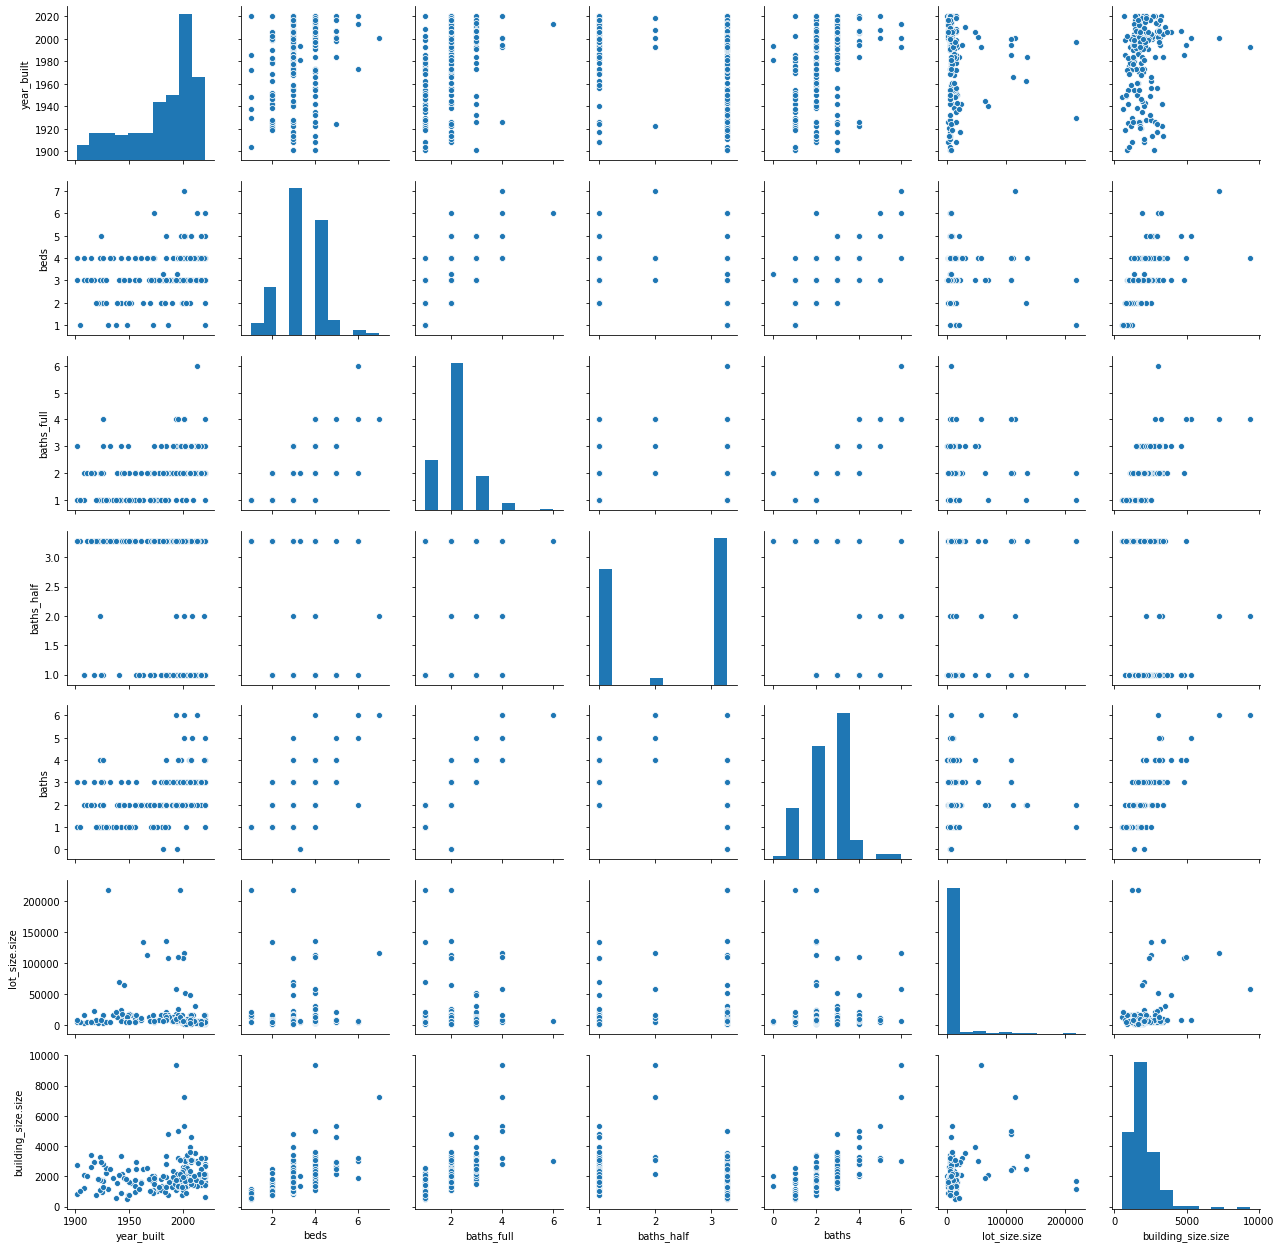

In [272]:
print(sns.pairplot(X_num_total))

## Machine Learning Models 

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X_clean,y, test_size=.2, random_state=42)

### Lasso Regression 

In [183]:
lasso = Lasso(alpha=152)

In [184]:
lasso.fit(X_train, y_train)

Lasso(alpha=152, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [185]:
lhat_train = lasso.predict(X_train)
mse_lasso_train = mean_squared_error(y_train, lhat_train)
print(mse_lasso_train)

5175583663.522939


In [186]:
r2_score(y_train,lhat_train)

0.890365076813631

In [187]:
lhat_test = lasso.predict(X_test)
mse_lasso_test = mean_squared_error(y_test, lhat_test)
print(mse_lasso_test)

12121326679.754602


In [188]:
r2_score(y_test,lhat_test)

0.6607781031362773

### Linear Regression

In [189]:
lm = LinearRegression(fit_intercept=True, normalize=False)
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [190]:
yhat_train = lm.predict(X_train)
mse_lm_train = mean_squared_error(y_train, yhat_train)
print(mse_lm_train)

5122353784.9493885


In [191]:
r2_score(y_train,yhat_train)

0.8914926508280869

In [192]:
yhat_test = lm.predict(X_test)
mse_lm_test = mean_squared_error(y_test, yhat_test)
print(mse_lm_test)

12075406712.23772


In [193]:
r2_score(y_test,yhat_test)

0.6620631983157526

### K Nearest Neighbors Regression 

In [194]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [195]:
yhat_knn_train = knn.predict(X_train)
mse_knn_train = mean_squared_error(y_train, yhat_knn_train)
print(mse_knn_train)

28303747952.598625


In [196]:
r2_score(y_train,yhat_knn_train)

0.4004387844138757

In [197]:
yhat_knn_test = knn.predict(X_test)
mse_knn_test = mean_squared_error(y_test, yhat_knn_test)
print(mse_knn_test)

32745067779.4435


In [198]:
r2_score(y_test,yhat_knn_test)

0.08361153044190761

### Decision Tree Regression 

In [199]:
regressor = DecisionTreeRegressor(min_samples_leaf=3)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [200]:
rhat_train = regressor.predict(X_train)
mse_regressor_train = mean_squared_error(y_train,rhat_train)
print(mse_regressor_train)

10004675362.088022


In [201]:
r2_score(y_train,rhat_train)

0.7880699287004739

In [202]:
rhat_test = regressor.predict(X_test)
mse_regressor_test = mean_squared_error(y_test,rhat_test)
print(mse_regressor_test)


22251607651.870773


In [203]:
r2_score(y_test,rhat_test)

0.37727669954294596

## Add Polynomial Features 

In [204]:
from sklearn.preprocessing import PolynomialFeatures

In [205]:
poly = PolynomialFeatures(2)

In [206]:
X_poly = pd.DataFrame(poly.fit_transform(X_num))

In [207]:
X_clean_poly = X_poly.join(X_cat)

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X_poly,y, test_size=.2, random_state=42)

### Linear Regression

In [209]:
lm = LinearRegression(fit_intercept=True, normalize=False)
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [210]:
yhat_train = lm.predict(X_train)
mse_lm_train = mean_squared_error(y_train, yhat_train)
print(mse_lm_train)

7581265325.248904


In [211]:
r2_score(y_train,yhat_train)

0.8394052737573986

In [212]:
yhat_test = lm.predict(X_test)
mse_lm_test = mean_squared_error(y_test, yhat_test)
print(mse_lm_test)

34749811198.71855


In [213]:
r2_score(y_test,yhat_test)

0.02750769928723762

### Lasso Regression 

In [214]:
lasso = Lasso(alpha=152)

In [215]:
lasso.fit(X_train, y_train)

Lasso(alpha=152, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [216]:
lhat_train = lasso.predict(X_train)
mse_lasso_train = mean_squared_error(y_train, lhat_train)
print(mse_lasso_train)

6281078129.550999


In [217]:
r2_score(y_train,lhat_train)

0.8669472733840091

In [218]:
lhat_test = lasso.predict(X_test)
mse_lasso_test = mean_squared_error(y_test, lhat_test)
print(mse_lasso_test)

32019950426.244427


In [219]:
r2_score(y_test,lhat_test)

0.10390433258309795

### K Nearest Neighbors Regression 

In [220]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [221]:
yhat_knn_train = knn.predict(X_train)
mse_knn_train = mean_squared_error(y_train, yhat_knn_train)
print(mse_knn_train)

29564198618.996502


In [222]:
r2_score(y_train,yhat_knn_train)

0.3737385277907076

In [223]:
yhat_knn_test = knn.predict(X_test)
mse_knn_test = mean_squared_error(y_test, yhat_knn_test)
print(mse_knn_test)

33119974642.387


In [224]:
r2_score(y_test,yhat_knn_test)

0.0731195586837885

### Decision Tree Regression 

In [225]:
regressor = DecisionTreeRegressor(min_samples_leaf=3)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [226]:
rhat_train = regressor.predict(X_train)
mse_regressor_train = mean_squared_error(y_train,rhat_train)
print(mse_regressor_train)

10135651402.517187


In [227]:
r2_score(y_train,rhat_train)

0.7852954497111937

In [228]:
rhat_test = regressor.predict(X_test)
mse_regressor_test = mean_squared_error(y_test,rhat_test)
print(mse_regressor_test)


29453989728.833668


In [229]:
r2_score(y_test,rhat_test)

0.17571413344485154

## Standard Scaler 

In [230]:
from sklearn.preprocessing import StandardScaler

In [231]:
scaler = StandardScaler()

In [232]:
X_scaler = pd.DataFrame(scaler.fit_transform(X_num))

In [233]:
X_scaler_clean = X_scaler.join(X_cat)

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X_scaler_clean,y, test_size=.2, random_state=42)

### Linear Regression

In [235]:
lm = LinearRegression(fit_intercept=True, normalize=False)
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [236]:
yhat_train = lm.predict(X_train)
mse_lm_train = mean_squared_error(y_train, yhat_train)
print(mse_lm_train)

5122457382.975


In [237]:
r2_score(y_train,yhat_train)

0.8914904563004126

In [238]:
yhat_test = lm.predict(X_test)
mse_lm_test = mean_squared_error(y_test, yhat_test)
print(mse_lm_test)

8.657152201424125e+32


In [239]:
r2_score(y_test,yhat_test)

-2.4227509651315645e+22

### Lasso Regression 

In [240]:
lasso = Lasso(alpha=152)

In [241]:
lasso.fit(X_train, y_train)

Lasso(alpha=152, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [242]:
lhat_train = lasso.predict(X_train)
mse_lasso_train = mean_squared_error(y_train, lhat_train)
print(mse_lasso_train)

5176504163.138428


In [243]:
r2_score(y_train,lhat_train)

0.8903455777752233

In [244]:
lhat_test = lasso.predict(X_test)
mse_lasso_test = mean_squared_error(y_test, lhat_test)
print(mse_lasso_test)

12162778030.956032


In [245]:
r2_score(y_test,lhat_test)

0.6596180646063696

### K Nearest Neighbors Regression 

In [246]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [247]:
yhat_knn_train = knn.predict(X_train)
mse_knn_train = mean_squared_error(y_train, yhat_knn_train)
print(mse_knn_train)

20260761190.451874


In [248]:
r2_score(y_train,yhat_knn_train)

0.5708142035326385

In [249]:
yhat_knn_test = knn.predict(X_test)
mse_knn_test = mean_squared_error(y_test, yhat_knn_test)
print(mse_knn_test)

20226741827.94225


In [250]:
r2_score(y_test,yhat_knn_test)

0.4339436670981397

### Decision Tree Regression 

In [251]:
regressor = DecisionTreeRegressor(min_samples_leaf=3)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [252]:
rhat_train = regressor.predict(X_train)
mse_regressor_train = mean_squared_error(y_train,rhat_train)
print(mse_regressor_train)

10004675362.088022


In [253]:
r2_score(y_train,rhat_train)

0.7880699287004739

In [254]:
rhat_test = regressor.predict(X_test)
mse_regressor_test = mean_squared_error(y_test,rhat_test)
print(mse_regressor_test)


22243338901.870773


In [255]:
r2_score(y_test,rhat_test)

0.3775081049933392

## Summary Of Model Performace

The two best models from the r^2 and mse results are linear regression and lasso regression under the original unaltered data. Lasso under the standard scaler also performed well. The best model is the Lasso regression under the original unaltered data. The r^2 was high at explaining 89% of the data for the training data and explained 66% of the data for the testing data. The mse was also lower for the testing data then the training so this looks good for the model.

Overall, under Lasso regression using the original unaltered data the features used created a model that was good at determining housing prices and could be used by Real Estate or other corperations to evaluate housing prices in the Vancovuer Washington area using housing features and geographic location.

## Conclusion 

Overall, for this data set the original data appeared to perform the best using the r^2 and mse evaluation metrics. Data transformations were not necessary for this data set. Some future features that would be interesting to add are adding amenities such as air conditions (central air or window units), garden house/external storage, quality of appliances, yard condition, etc. All of these features and other potential predictors would change the model and allow for more data analysis. However, the current Realter API does not provide this information so another API or dataset would need to be found. Another limitation was that the free API only provided 200 rows of housing data. The API would need to be upgraded to the paid subscription to receive more data lines.